# Foodgroup for OpenFoodFacts

**Objective** : <br>
Predict the foodgroup (12 groups) of a product of Open Food Facts <br>
Remark : cannot run without the file `data/openfoodfacts.csv` (85Mo) <br>

**Main results** : <br>
- using 6 nutrients and random forest : 88.5% of accuracy (87.5% for a simpler model)
- using names and naive bayes : 87% of accuracy

**Outputs** : <br>
- `data/clf_nutrients_rf_groupeAlim_2.sav` (292Mo) : random forest model (88.5% of accuracy)
- `data/clf_nutrients_rf_groupeAlim_2_light.sav` (20Mo) : simple random forest model (87.5% of accuracy)
- `data/openfoodfacts_groupeAlim_2.csv` (31Mo) : assign a foodgroup to OpenFoodFacts' products

In [25]:
import numpy as np
import pandas as pd
import time
import sys
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#from nltk.tokenize import RegexpTokenizer
#unidecodeimport unidecode
#from collections import Counter
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import pickle

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

## Opening files

In [2]:
# Open Food Facts
openfoodfacts = pd.read_csv("../../data/openfoodfacts.csv", sep = ';', 
                                      encoding = 'UTF-8', dtype = {'EAN': str, 'product_name' : str})
openfoodfacts.rename(columns={'saturatedFat_100g':'saturated-fat_100g'}, inplace=True)

# Mapping groups
mapping_groups = pd.read_csv("../../data/mapping_off_ideal.csv", sep = ';', encoding = 'UTF-8')

# Add groups
openfoodfacts = openfoodfacts.merge(mapping_groups, how = 'left')

In [34]:
openfoodfacts.head(10)

,EAN,product_name,quantity,countries_fr,serving_size,serving_quantity,nutriscore,pnns_groups_1,pnns_groups_2,categories_tags,energy_100g,carbohydrates_100g,fat_100g,saturated-fat_100g,transFat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,vitaminA_100g,vitaminC_100g,calcium_100g,iron_100g,score_nutritif_100g,groupeAlim_1,groupeAlim_2
0,0000000000017,Vitória crackers,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,1569.0,70.1,7.0,3.08,NaN,15.0,NaN,7.8,1.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,Cacao,130 g,France,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,Sauce Sweety chili 0%,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,88.0,4.8,0.0,0.00,NaN,0.4,NaN,0.2,2.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000291,Mendiants,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,Salade de carottes râpées,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,134.0,5.3,0.3,0.10,NaN,3.9,NaN,0.9,0.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000000000970,Fromage blanc aux myrtilles,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,540.0,16.3,4.9,3.10,NaN,16.3,NaN,4.4,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0000000001001,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0000000001007,Vainilla,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0000000001137,Baguette parisien,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,929.0,38.4,3.3,2.10,NaN,1.8,NaN,11.7,0.678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0000000001151,&quot;Baguette Lyonnais&quot;,NaN,France,NaN,0.0,NaN,NaN,NaN,NaN,1213.0,41.0,9.4,4.50,NaN,2.0,NaN,12.5,0.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Machine learning

In [4]:
# Choose between pnns_groups_1, pnns_groups_2, (groupeAlim_1), groupeAlim_2
# This is the name of the target variable
level_groupe = "groupeAlim_2"

### Using nutrients

In [5]:
# Only keeping observations where the food group is valid and removing easy outliers
openfoodfacts_ml_nutrients = openfoodfacts[pd.notnull(openfoodfacts[level_groupe])] #has the food group

# With valid nutrients
openfoodfacts_ml_nutrients = openfoodfacts_ml_nutrients[openfoodfacts_ml_nutrients['salt_100g'] <= 100]
openfoodfacts_ml_nutrients = openfoodfacts_ml_nutrients[openfoodfacts_ml_nutrients['sugars_100g'] <= 100]
openfoodfacts_ml_nutrients = openfoodfacts_ml_nutrients[openfoodfacts_ml_nutrients['carbohydrates_100g'] <= 100]
openfoodfacts_ml_nutrients = openfoodfacts_ml_nutrients[openfoodfacts_ml_nutrients['fat_100g'] <= 100]
openfoodfacts_ml_nutrients = openfoodfacts_ml_nutrients[openfoodfacts_ml_nutrients['proteins_100g'] <= 100]
openfoodfacts_ml_nutrients = openfoodfacts_ml_nutrients[openfoodfacts_ml_nutrients['saturated-fat_100g'] <= 100]

openfoodfacts_ml_nutrients.shape #110274 x 26

(110274, 26)

In [42]:
# Train and test sets
train_x, test_x, train_y, test_y = model_selection.train_test_split(openfoodfacts_ml_nutrients[['salt_100g', 'sugars_100g',
                                                                                    'carbohydrates_100g', 'fat_100g',
                                                                                    'proteins_100g', 'saturated-fat_100g']],
                                                                    openfoodfacts_ml_nutrients[level_groupe],
                                                                    test_size = 0.2)

print("Among the %.0f observations of the database of Open Food Facts, only %.0f are useful for this methodology.\n \
      \tIn the training dataset, there are %.0f observations.\n\tIn the test dataset, there are %.0f observations." % 
      (openfoodfacts.shape[0], openfoodfacts_ml_nutrients.shape[0], train_x.shape[0], test_x.shape[0]))

Among the 677830 observations of the database of Open Food Facts, only 110274 are useful for this methodology.
       	In the training dataset, there are 88219 observations.
	In the test dataset, there are 22055 observations.


#### Random forest

In [7]:
?RandomForestClassifier

In [43]:
# Learning 
print('Learning step ...')
clf_nutrients_rf = RandomForestClassifier(random_state = 50, n_jobs = -1,
                                          max_features = 2, criterion = 'entropy', n_estimators = 100,
                                          max_depth = 40)
clf_nutrients_rf.fit(train_x, train_y)

# Prediction
print('Prediction step ...')
predictions = clf_nutrients_rf.predict(test_x)
accuracy_model = accuracy_score(y_true = test_y, y_pred = predictions)
print('%s - Accuracy of the random forest model : %.2f%%' % (level_groupe, 100 * accuracy_model)) 
#pnns_groups_2 : 82.0%
#pnns_groups_1 : 88.7%, 
#groupeAlim_2 : 88.5%

Learning step ...
Prediction step ...
groupeAlim_2 - Accuracy of the random forest model : 88.69%


In [44]:
# Learning simpler and lighter model
# This model requires less memory to be stored and is quicker to compute

clf_nutrients_rf_light = RandomForestClassifier(random_state = 50, n_jobs = -1,
                                          max_features = 3, criterion = 'entropy', n_estimators = 15,
                                          max_depth = 20, min_samples_split = 4, min_samples_leaf = 4)
clf_nutrients_rf_light.fit(train_x, train_y)

# Prediction
predictions_light = clf_nutrients_rf_light.predict(test_x)
accuracy_model_light = accuracy_score(y_true = test_y, y_pred = predictions_light)
print('%s - Accuracy of the light random forest model : %.2f%%' % (level_groupe, 100 * accuracy_model_light)) 
# groupeAlim_2 :87.5%

groupeAlim_2 - Accuracy of the light random forest model : 87.90%


Let's optimize the hyperparameters ! 

Estimation for 10
Estimation for 25
Estimation for 50
Estimation for 100
Estimation for 200
Estimation for 300
   n_estimator  training_accuracy  validation_accuracy
0           10              98.65                87.32
1           25              99.16                88.10
2           50              99.25                88.37
3          100              99.28                88.40
4          200              99.28                88.55
5          300              99.28                88.59


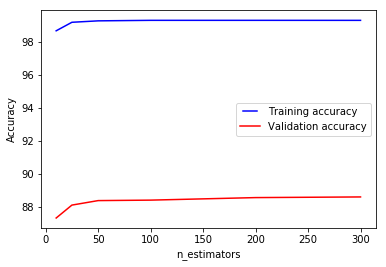

In [10]:
# Optimization for n_estimators
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
#list_n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
list_n_estimators = [10, 25, 50, 100, 200, 300]

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_n_estimators : 
    
    print("Estimation for %s" % hyp)
     
    # Fit the data
    rf = RandomForestClassifier(n_estimators=hyp, n_jobs=-1)
    rf.fit(training_x, training_y)

    # Prediction
    training_pred = rf.predict(training_x)
    valid_pred = rf.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'n_estimator' : list_n_estimators,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_n_estimators, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_n_estimators, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()    

Estimation for max_features = 1
Estimation for max_features = 2
Estimation for max_features = 3
Estimation for max_features = 4
Estimation for max_features = 5
   max_features  training_accuracy  validation_accuracy
0             1              99.24                88.29
1             2              99.25                88.21
2             3              99.23                88.53
3             4              99.23                88.39
4             5              99.24                88.33


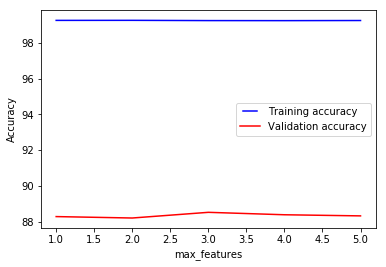

In [12]:
# Optimization for max_features
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_max_features = [1,2,3,4,5]

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_max_features : 
    
    print("Estimation for max_features = %s" % hyp)
     
    # Fit the data
    rf = RandomForestClassifier(max_features=hyp, n_jobs=-1, n_estimators = 50)
    rf.fit(training_x, training_y)

    # Prediction
    training_pred = rf.predict(training_x)
    valid_pred = rf.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'max_features' : list_max_features,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_max_features, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_max_features, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('max_features')
plt.show()    

Estimation for max_depth = 10
Estimation for max_depth = 20
Estimation for max_depth = 30
Estimation for max_depth = 40
Estimation for max_depth = 50
Estimation for max_depth = 60
Estimation for max_depth = None
   max_depth  training_accuracy  validation_accuracy
0       10.0              86.29                84.83
1       20.0              98.24                88.17
2       30.0              99.22                88.17
3       40.0              99.26                88.17
4       50.0              99.26                88.14
5       60.0              99.26                88.19
6        NaN              99.26                88.14


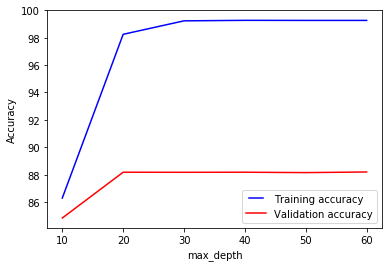

In [13]:
# Optimization for max_depth
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_max_depth = [int(x) for x in np.linspace(10, 60, num = 6)]
list_max_depth.append(None)

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_max_depth : 
    
    print("Estimation for max_depth = %s" % hyp)
     
    # Fit the data
    rf = RandomForestClassifier(max_depth=hyp, n_jobs=-1, n_estimators = 50)
    rf.fit(training_x, training_y)

    # Prediction
    training_pred = rf.predict(training_x)
    valid_pred = rf.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'max_depth' : list_max_depth,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_max_depth, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_max_depth, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('max_depth')
plt.show()    

Estimation for min_samples_split = 2
Estimation for min_samples_split = 4
Estimation for min_samples_split = 6
Estimation for min_samples_split = 8
Estimation for min_samples_split = 10
Estimation for min_samples_split = 12
Estimation for min_samples_split = 14
Estimation for min_samples_split = 16
   min_samples_split  training_accuracy  validation_accuracy
0                  2              99.28                88.32
1                  4              98.23                88.34
2                  6              96.68                88.22
3                  8              95.45                88.13
4                 10              94.38                88.05
5                 12              93.60                87.90
6                 14              92.96                87.99
7                 16              92.40                87.80


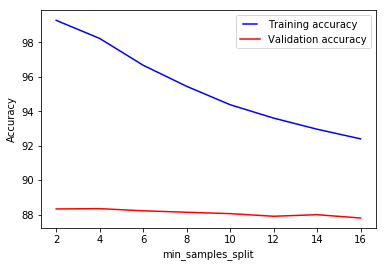

In [14]:
# Optimization for min_samples_split
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_min_samples_split = [2,4,6,8,10,12,14,16]

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_min_samples_split : 
    
    print("Estimation for min_samples_split = %s" % hyp)
     
    # Fit the data
    rf = RandomForestClassifier(min_samples_split=hyp, n_jobs=-1, n_estimators = 50)
    rf.fit(training_x, training_y)

    # Prediction
    training_pred = rf.predict(training_x)
    valid_pred = rf.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'min_samples_split' : list_min_samples_split,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_min_samples_split, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_min_samples_split, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('min_samples_split')
plt.show()    

Estimation for min_samples_leaf = 1
Estimation for min_samples_leaf = 3
Estimation for min_samples_leaf = 5
Estimation for min_samples_leaf = 7
Estimation for min_samples_leaf = 9
Estimation for min_samples_leaf = 11
Estimation for min_samples_leaf = 13
Estimation for min_samples_leaf = 15
   min_samples_leaf  training_accuracy  validation_accuracy
0                 1              99.25                88.04
1                 3              94.12                87.93
2                 5              91.85                87.54
3                 7              90.45                87.24
4                 9              89.51                87.00
5                11              88.88                86.73
6                13              88.45                86.50
7                15              87.96                86.36


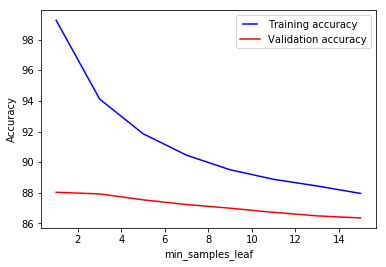

In [15]:
# Optimization for min_samples_leaf
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_min_samples_leaf = [1, 3, 5, 7, 9, 11, 13, 15]

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_min_samples_leaf : 
    
    print("Estimation for min_samples_leaf = %s" % hyp)
     
    # Fit the data
    rf = RandomForestClassifier(min_samples_leaf=hyp, n_jobs=-1, n_estimators = 50)
    rf.fit(training_x, training_y)

    # Prediction
    training_pred = rf.predict(training_x)
    valid_pred = rf.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'min_samples_leaf' : list_min_samples_leaf,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_min_samples_leaf, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_min_samples_leaf, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('min_samples_leaf')
plt.show()    

In [16]:
# Optimization for criterion
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_criterion = ['gini', 'entropy']

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_criterion : 
    
    print("Estimation for criterion = %s" % hyp)
     
    # Fit the data
    rf = RandomForestClassifier(criterion=hyp, n_jobs=-1, n_estimators = 50)
    rf.fit(training_x, training_y)

    # Prediction
    training_pred = rf.predict(training_x)
    valid_pred = rf.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'criterion' : list_criterion,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

Estimation for criterion = gini
Estimation for criterion = entropy
  criterion  training_accuracy  validation_accuracy
0      gini              99.28                88.01
1   entropy              99.28                88.11


According to these 1-dimensional analysis, one gets the following intuition : 
- n_estimators : the greater, the better. Over 50, the gain is not very interesting ;
- max_features : 2 or 3 seem correct ;
- max_depth : 20 seems to be a correct threshold ;
- min_samples_split : best performance for 2-8 ;
- min_samples_leaf : the lower, the better ;
- criterion : not a big difference between gini and entropy

Let's try a random grid search : 

In [19]:
# Optimization with a random grid search

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
#n_estimators = [5, 10, 15]
n_estimators = [40, 50, 100, 200]

# Number of features to consider at every split
max_features = [2,3]
# Maximum number of levels in tree
max_depth = [10, 20, 30]
# Minimum number of samples required to split a node
min_samples_split = [4, 8, 16]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]
# Criterion
criterion = ['entropy', 'gini']

# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'criterion' : criterion}
random_grid = {'n_estimators': [100],
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               'criterion' : criterion}

In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_nutrients_rf_to_optimize = RandomForestClassifier()

# Random search of parameters, using cv fold cross validation, 
# search across different combinations, and use all available cores
random_grid_search = model_selection.RandomizedSearchCV(estimator = clf_nutrients_rf_to_optimize, 
                                                           param_distributions = random_grid,
                                                           n_iter = 12, cv = 5, 
                                                           verbose=2, random_state=214, n_jobs = -1)

# Fit the random search model
random_grid_search.fit(train_x, train_y)

# Evaluate the best hyperparameters
print(random_grid_search.best_params_)

# Prediction
prediction = random_grid_search.predict(test_x)
accuracy_model = accuracy_score(y_true = test_y, y_pred = prediction)
print('%s - Accuracy of the random forest model : %.2f%%' % (level_groupe, 100 * accuracy_model))

# pnns_groups_2 : 82.05% with {'n_estimators': 300, 'criterion': 'entropy', 'max_features': 2}
# pnns_groups_1 : 88.79% with {'n_estimators': 200, 'criterion': 'entropy', 'max_features': 2}
# groupeAlim_2 : 88.47% with {'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 2, 'n_estimators': 100, 'max_depth': 40}

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.2min finished


{'min_samples_split': 2, 'max_depth': 20, 'criterion': 'entropy', 'min_samples_leaf': 1, 'max_features': 2, 'n_estimators': 100}
groupeAlim_2 - Accuracy of the random forest model : 88.61%


In [27]:
cv_results = pd.DataFrame(random_grid_search.cv_results_)
cv_results.sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,42.048444,1.441499,0.882701,0.989934,entropy,20,2,1,2,100,"{'min_samples_split': 2, 'max_depth': 20, 'cri...",1,0.883500,0.990435,0.877373,0.990067,0.883990,0.989670,0.884020,0.989898,0.884624,0.989601,1.765694,0.138146,0.002688,0.000300
4,48.533584,1.784503,0.882372,0.992893,entropy,30,2,1,2,100,"{'min_samples_split': 2, 'max_depth': 30, 'cri...",2,0.882990,0.993085,0.877543,0.992802,0.884387,0.992802,0.883793,0.992930,0.883150,0.992845,9.176633,0.501063,0.002465,0.000107
5,90.366794,2.046470,0.881964,0.992887,entropy,30,3,1,2,100,"{'min_samples_split': 2, 'max_depth': 30, 'cri...",3,0.881800,0.993099,0.877713,0.992802,0.885123,0.992802,0.882886,0.992930,0.882300,0.992803,6.908306,0.477994,0.002410,0.000117
10,32.772967,1.637807,0.881783,0.992666,gini,30,2,1,2,100,"{'min_samples_split': 2, 'max_depth': 30, 'cri...",4,0.883046,0.992802,0.877033,0.992632,0.883876,0.992561,0.882773,0.992646,0.882186,0.992689,1.105954,0.290947,0.002437,0.000079
3,58.026631,1.262277,0.881681,0.990351,entropy,20,3,1,2,100,"{'min_samples_split': 2, 'max_depth': 20, 'cri...",5,0.880723,0.990619,0.877600,0.990605,0.884613,0.989699,0.882433,0.990535,0.883037,0.990295,4.189044,0.066066,0.002391,0.000346
8,33.733495,1.548227,0.881375,0.983657,gini,20,2,1,2,100,"{'min_samples_split': 2, 'max_depth': 20, 'cri...",6,0.882196,0.983704,0.876240,0.983790,0.883196,0.983252,0.882150,0.983819,0.883093,0.983721,0.775491,0.265407,0.002605,0.000207
11,41.522428,1.372935,0.881023,0.992502,gini,30,3,1,2,100,"{'min_samples_split': 2, 'max_depth': 30, 'cri...",7,0.879873,0.992547,0.876806,0.992547,0.884613,0.992547,0.882206,0.992533,0.881619,0.992335,2.644617,0.192973,0.002598,0.000083
9,41.357578,1.600569,0.880865,0.983649,gini,20,3,1,2,100,"{'min_samples_split': 2, 'max_depth': 20, 'cri...",8,0.881573,0.983903,0.876126,0.984144,0.882460,0.982657,0.882150,0.983763,0.882016,0.983778,1.166317,0.223857,0.002387,0.000515
1,43.109686,1.084910,0.855496,0.873828,entropy,10,3,1,2,100,"{'min_samples_split': 2, 'max_depth': 10, 'cri...",9,0.859644,0.873815,0.852100,0.873817,0.855823,0.874231,0.857548,0.873091,0.852364,0.874187,3.309407,0.047645,0.002928,0.000409
0,28.178852,1.024876,0.853184,0.870637,entropy,10,2,1,2,100,"{'min_samples_split': 2, 'max_depth': 10, 'cri...",10,0.858114,0.870428,0.848983,0.872074,0.852649,0.870165,0.855054,0.870300,0.851117,0.870220,1.378752,0.126746,0.003163,0.000724


#### Support Vector Machine

In [ ]:
# Learning 
#clf_nutrients_svc = svm.SVC(random_state = 0)
#clf_nutrients_svc.fit(train_x, train_y)

# Prediction
#prediction = clf_nutrients_svc.predict(test_x)
#accuracy_model = accuracy_score(y_true = test_y, y_pred = prediction)
#print('Accuracy of the SVC model : %.2f%%' % (100 * accuracy_model)) #pnns_groups_1 : 85% vs 88% for rf

#### Gradient boosting classifier

In [ ]:
# Learning 
#clf_nutrients_gbc = GradientBoostingClassifier(random_state = 0)
#clf_nutrients_gbc.fit(train_x, train_y)

# Prediction
#prediction = clf_nutrients_gbc.predict(test_x)
#accuracy_model = accuracy_score(y_true = test_y, y_pred = prediction)
#print('Accuracy of the gradient boosting model : %.2f%%' % (100 * accuracy_model)) #pnns_groups_2 : 77% vs 82% for rf

### Using names

In [28]:
# Only keeping observations where the food group is valid and with a name
openfoodfacts_ml_names = openfoodfacts[pd.notnull(openfoodfacts[level_groupe])] #has the food group

# With a valid name
openfoodfacts_ml_names = openfoodfacts_ml_names[pd.notnull(openfoodfacts_ml_names['product_name'])]

openfoodfacts_ml_names.shape #133303 x 26

(133003, 26)

In [29]:
# Training and test sets
train_x, test_x, train_y, test_y = model_selection.train_test_split(openfoodfacts_ml_names['product_name'],
                                                                    openfoodfacts_ml_names[level_groupe],
                                                                    test_size = 0.2)

print("Among the %.0f observations of the database of Open Food Facts, only %.0f are useful for this methodology.\n \
      \tIn the training dataset, there are %.0f observations.\n\tIn the test dataset, there are %.0f observation" % 
      (openfoodfacts.shape[0], openfoodfacts_ml_names.shape[0], train_x.shape[0], test_x.shape[0]))

Among the 677830 observations of the database of Open Food Facts, only 133003 are useful for this methodology.
       	In the training dataset, there are 106402 observations.
	In the test dataset, there are 26601 observation


#### Naive bayes

In [30]:
# Firstly, let's create a pipeline which will contains all hyper-parameters
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')), 
                                         min_df = 1,
                                         ngram_range = (1,3))),
    ('naive_bayes', naive_bayes.MultinomialNB(alpha = 1e-3))
    ])

# Fit the model
pipeline.fit(train_x, train_y)

# Predict the labels on validation dataset
prediction = pipeline.predict(test_x)
accuracy_model = accuracy_score(y_true = test_y, y_pred = prediction)
print('Accuracy of the naive bayes model : %.2f%%' % (100 * accuracy_model)) 

Accuracy of the naive bayes model : 86.77%


Let's optimize hyper-parameters

In [31]:
# Optimization with a random grid search

# Alpha smoothing parameters
alpha = [0, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

#N-grams
ngram_range = [(1,1), (1,2), (1,3)]

# Minimal number of occurences
min_df = [1,2,3]

# Create the random grid
# Note : follow the notation : MODEL__PARAM ! 
random_grid = {'naive_bayes__alpha': alpha,
               'count_vectorizer__ngram_range' : ngram_range,
               'count_vectorizer__min_df': min_df}

In [32]:
# Use the random grid to search for best hyperparameters

# Firstly, let's create a pipeline which will contains all hyper-parameters
pipeline_to_optimize = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')))),
    ('naive_bayes', naive_bayes.MultinomialNB())
    ])

# All parameters to tune =)
# pipeline_to_optimize.get_params().keys()

# Random search of parameters, using cv fold cross validation, 
# search across different combinations, and use all available cores
random_grid_search = model_selection.RandomizedSearchCV(estimator = pipeline_to_optimize, 
                                                   param_distributions = random_grid,
                                                   n_iter = 25, cv = 5,
                                                   verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
random_grid_search.fit(train_x, train_y)

# Evaluate the best hyperparameters
print(random_grid_search.best_params_)

# Prediction
predictions = random_grid_search.predict(test_x)
accuracy_model = accuracy_score(y_true = test_y, y_pred = predictions)
print('Accuracy of the best naive bayes model : %.2f%%' % (100 * accuracy_model))


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.1min finished


{'count_vectorizer__ngram_range': (1, 2), 'naive_bayes__alpha': 0.1, 'count_vectorizer__min_df': 1}
Accuracy of the best naive bayes model : 86.95%


In [33]:
cv_results = pd.DataFrame(random_grid_search.cv_results_)
cv_results.sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_count_vectorizer__min_df,param_count_vectorizer__ngram_range,param_naive_bayes__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
15,6.340238,1.058096,0.865144,0.955064,1,"(1, 2)",0.1,"{'count_vectorizer__ngram_range': (1, 2), 'nai...",1,0.866479,0.955097,0.863942,0.955332,0.866300,0.954325,0.867933,0.954925,0.861064,0.955642,0.080304,0.025373,0.002408,0.000441
6,8.449456,1.426413,0.864956,0.971321,1,"(1, 3)",0.01,"{'count_vectorizer__ngram_range': (1, 3), 'nai...",2,0.868452,0.970758,0.862297,0.971733,0.865407,0.970725,0.868356,0.971830,0.860265,0.971560,0.325657,0.166152,0.003257,0.000481
1,6.644428,1.034762,0.863377,0.949759,1,"(1, 2)",0.2,"{'count_vectorizer__ngram_range': (1, 2), 'nai...",3,0.864787,0.949658,0.861452,0.949775,0.865783,0.948862,0.865677,0.949709,0.859184,0.950791,0.355170,0.066717,0.002621,0.000613
0,7.697450,1.297483,0.854448,0.916289,2,"(1, 3)",0.01,"{'count_vectorizer__ngram_range': (1, 3), 'nai...",4,0.858116,0.914729,0.852525,0.917044,0.854692,0.915828,0.857546,0.916852,0.849361,0.916994,0.593889,0.083777,0.003246,0.000898
12,8.749747,1.398028,0.853706,0.941841,1,"(1, 3)",0.5,"{'count_vectorizer__ngram_range': (1, 3), 'nai...",5,0.854827,0.941422,0.853653,0.942444,0.854927,0.940698,0.855102,0.941909,0.850019,0.942732,0.223795,0.045179,0.001913,0.000727
22,11.831638,1.871919,0.852954,0.901029,2,"(1, 3)",0.3,"{'count_vectorizer__ngram_range': (1, 3), 'nai...",6,0.853418,0.899656,0.852102,0.901829,0.854504,0.900332,0.856324,0.901028,0.848421,0.902298,1.024601,0.276042,0.002655,0.000961
24,10.355648,1.691465,0.851742,0.921219,2,"(1, 2)",0,"{'count_vectorizer__ngram_range': (1, 2), 'nai...",7,0.854874,0.919581,0.849941,0.922001,0.851967,0.920985,0.854162,0.921739,0.847763,0.921787,2.438258,0.436145,0.002638,0.000888
5,8.384682,1.337049,0.851488,0.898193,2,"(1, 3)",0.4,"{'count_vectorizer__ngram_range': (1, 3), 'nai...",8,0.852008,0.897142,0.850740,0.898681,0.853283,0.897431,0.854632,0.898162,0.846776,0.899549,0.095274,0.074597,0.002688,0.000868
14,8.908687,1.391218,0.850125,0.895643,2,"(1, 3)",0.5,"{'count_vectorizer__ngram_range': (1, 3), 'nai...",9,0.851116,0.894933,0.849941,0.895931,0.852578,0.894893,0.852705,0.895518,0.844285,0.896941,0.375269,0.127771,0.003092,0.000755
10,3.919834,0.737591,0.847644,0.908087,1,"(1, 1)",0.1,"{'count_vectorizer__ngram_range': (1, 1), 'nai...",10,0.849190,0.907903,0.847686,0.909031,0.849335,0.907029,0.851201,0.907512,0.840807,0.908958,0.066024,0.027876,0.003596,0.000792


Using names is not a better idea than using nutrients

## Prediction for products without food groups

### Using nutrients

In [35]:
# With valid nutrients
openfoodfacts_foodgroup_nutrients = openfoodfacts
openfoodfacts_foodgroup_nutrients = openfoodfacts_foodgroup_nutrients[openfoodfacts_foodgroup_nutrients['salt_100g'] <= 100]
openfoodfacts_foodgroup_nutrients = openfoodfacts_foodgroup_nutrients[openfoodfacts_foodgroup_nutrients['sugars_100g'] <= 100]
openfoodfacts_foodgroup_nutrients = openfoodfacts_foodgroup_nutrients[openfoodfacts_foodgroup_nutrients['carbohydrates_100g'] <= 100]
openfoodfacts_foodgroup_nutrients = openfoodfacts_foodgroup_nutrients[openfoodfacts_foodgroup_nutrients['fat_100g'] <= 100]
openfoodfacts_foodgroup_nutrients = openfoodfacts_foodgroup_nutrients[openfoodfacts_foodgroup_nutrients['proteins_100g'] <= 100]
openfoodfacts_foodgroup_nutrients = openfoodfacts_foodgroup_nutrients[openfoodfacts_foodgroup_nutrients['saturated-fat_100g'] <= 100]

openfoodfacts_foodgroup_nutrients.shape #518912 x 26

(518912, 26)

In [45]:
# Selected models
print(clf_nutrients_rf)
print(clf_nutrients_rf_light)

# Save the model to disk
filename = '../../data/clf_nutrients_rf_' + level_groupe +'.sav'
pickle.dump(clf_nutrients_rf, open(filename, 'wb'))

# Save the light model to disk
filename_light = '../../data/clf_nutrients_rf_' + level_groupe +'_light.sav'
pickle.dump(clf_nutrients_rf_light, open(filename_light, 'wb'))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=40, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)


In [37]:
# Prediction
openfoodfacts_foodgroup_nutrients[level_groupe + '_hat'] = clf_nutrients_rf.predict(openfoodfacts_foodgroup_nutrients[['salt_100g', 'sugars_100g',
                                                                                    'carbohydrates_100g', 'fat_100g',
                                                                                    'proteins_100g', 'saturated-fat_100g']])

In [38]:
# Do not replace foodgroup when it was available !
openfoodfacts_foodgroup_nutrients['foodgroup'] = np.where(pd.isnull(openfoodfacts_foodgroup_nutrients[level_groupe]), 
                                                          openfoodfacts_foodgroup_nutrients[level_groupe + '_hat'], 
                                                          openfoodfacts_foodgroup_nutrients[level_groupe])

In [39]:
openfoodfacts_foodgroup_nutrients[['EAN', 'product_name', 'pnns_groups_1', 'pnns_groups_2', 'groupeAlim_2', level_groupe + '_hat', 'foodgroup']].sample(100)

,EAN,product_name,pnns_groups_1,pnns_groups_2,groupeAlim_2,groupeAlim_2_hat,foodgroup
138107,0290779044675,Palette de porc a l'emmental,NaN,NaN,NaN,"Viande, oeufs","Viande, oeufs"
120717,0098437240335,"Casey's General Store, Assorted Fruit Sours",NaN,NaN,NaN,Produits gras sucrés salés,Produits gras sucrés salés
409970,3559040007052,Brioche aux fruits confits La Coupiagaise,NaN,NaN,NaN,Produits gras sucrés salés,Produits gras sucrés salés
145157,0621498710419,Protidiet Potage Arome Poulet,NaN,NaN,NaN,"Viande, oeufs","Viande, oeufs"
274717,3116740026136,Bestfizz,Sugary snacks,Sweets,Produits gras sucrés salés,Produits gras sucrés salés,Produits gras sucrés salés
88666,0072250045490,"Cobblestone Bread Co, Bagels, Original",NaN,NaN,NaN,Féculents raffinés,Féculents raffinés
395740,3474340020092,Chocolat en poudre goût épices,NaN,NaN,NaN,Produits gras sucrés salés,Produits gras sucrés salés
602802,7622300725051,Cadbury Dairy Milk With Crunchie,NaN,NaN,NaN,Produits gras sucrés salés,Produits gras sucrés salés
644180,8436014444516,Golosinas,NaN,NaN,NaN,Féculents raffinés,Féculents raffinés
130904,0211405023819,Jambon cuit superieur,NaN,NaN,NaN,"Viande, oeufs","Viande, oeufs"


In [40]:
openfoodfacts_foodgroup_nutrients.to_csv("../../data/openfoodfacts_" + level_groupe +".csv",
                                         sep = ';', encoding = 'UTF-8', index = False,
                                         columns = ["product_name", "EAN", "foodgroup"])